In [1]:
from openpiv import tools, pyprocess, scaling, filters, \
                    validation, preprocess
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

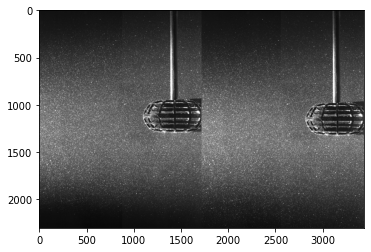

In [2]:
file_a = '../test4/Camera1-0101.tif'
file_b = '../test4/Camera1-0102.tif'

im_a  = tools.imread( file_a )
im_b  = tools.imread( file_b )
plt.imshow(np.c_[im_a,im_b],cmap='gray')

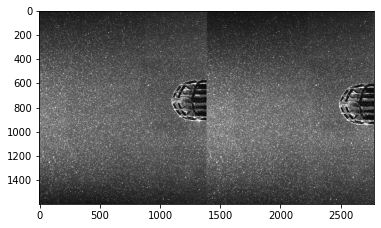

In [3]:
# let's crop the region of interest
frame_a =  im_a[380:1980,0:1390]
frame_b =  im_b[380:1980,0:1390]
plt.imshow(np.c_[frame_a,frame_b],cmap='gray')

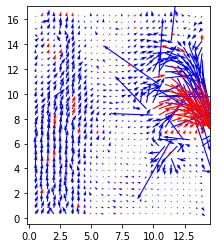

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [4]:
# Process the original cropped image and see the OpenPIV result:

# typical parameters:
window_size = 32 #pixels
overlap = 16 # pixels
search_area_size = 64 # pixels 
frame_rate = 40 # fps
scaling_factor = 96.52 # micron/pixel

# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = pyprocess.extended_search_area_piv(
                                                       frame_a.astype(np.int32) , frame_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = search_area_size, 
                                                       sig2noise_method = 'peak2peak')
x, y = pyprocess.get_coordinates(frame_a.shape, 
                               search_area_size, 
                               overlap )
mask_g = validation.global_val( u, v, (-300.,300.),(-300.,300.))
mask_s2n = validation.sig2noise_val(sig2noise, threshold = 1.1 )
mask = mask_g | mask_s2n 
u, v = filters.replace_outliers( u, v, mask, method='localmean', max_iter = 3, kernel_size = 3)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
# save to a file
x, y, u, v = tools.transform_coordinates(x, y, u, v)
tools.save('test.txt', x, y, u, v, mask)
tools.display_vector_field('test.txt', scale=5, width=0.006)

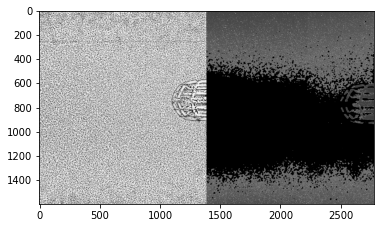

In [5]:
# masking using not optimal choice of the methods or parameters:
masked_a, _ = preprocess.dynamic_masking(frame_a,method='edges',filter_size=7,threshold=0.005)
masked_b, _ = preprocess.dynamic_masking(frame_b,method='intensity',filter_size=3,threshold=0.0)
plt.imshow(np.c_[masked_a,masked_b],cmap='gray')

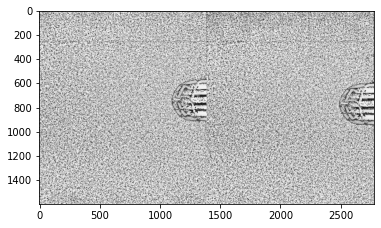

In [8]:
# masking using optimal (manually tuned) set of parameters and the right method:
masked_a, _ = preprocess.dynamic_masking(
    frame_a,
    method='edges',
    filter_size=15,
    threshold=0.005
)
masked_b, _ = preprocess.dynamic_masking(
    frame_b,
    method='edges',
    filter_size=15,
    threshold=0.005
)
plt.imshow(np.c_[masked_a,masked_b],cmap='gray')

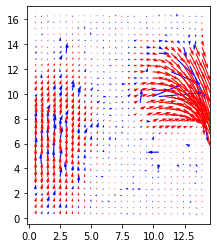

In [9]:
# Process the masked cropped image and see the OpenPIV result:

# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = pyprocess.extended_search_area_piv(
                                                       masked_a.astype(np.int32) , masked_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = search_area_size, 
                                                       sig2noise_method = 'peak2peak')
x, y = pyprocess.get_coordinates(masked_a.shape, 
                               search_area_size, 
                               overlap )
mask_g = validation.global_val( u, v, (-300.,300.),(-300.,300.))
mask_s2n = validation.sig2noise_val(sig2noise, threshold = 1.1)
mask = mask_g | mask_s2n
u, v = filters.replace_outliers( u, v, mask, method='localmean', max_iter = 3, kernel_size = 3)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = scaling_factor )
# save to a file
x, y, u, v = tools.transform_coordinates(x, y, u, v)
tools.save('test_masked.txt', x, y, u, v, None, mask, fmt='%9.6f', delimiter='\t')
tools.display_vector_field('test_masked.txt', scale=5, width=0.006);